### Introduction

This notebook helps to have a first look at the saved output, reading into hdf files. It helps to concatenate more runs and more periods, one after the other. It is helpful to monitor the system over a larger period of time usually set as a run.

It works after having installed the repo 'legend-data-monitor'. In particular, after the cloning, enter into the folder and install the package by typing

```console
foo@bar:~$ pip install .
```

# Select period to inspect

In [4]:
import os
import sys
import json
import h5py
import shelve
import matplotlib
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from legend_data_monitor import plot_styles, plotting, utils
import legend_data_monitor as ldm

# ------------------------------------------------------------------------------------------ which data do you want to read? CHANGE ME!
run = "r004"  # r000, r001, ...
subsystem = "geds"  # KEEP 'geds' for the moment
folder = "../attic/automatic_prod/p15"  # you can change me
prodenv_path = "/global/cfs/cdirs/m2676/data/lngs/l200/public/prodenv/prod-blind/"
periods = ["p15"] # list of periods to concatenate
version = "tmp-auto"

# ------------------------------------------------------------------------------------------ remove detectors from the plots
# do you want to remove some detectors? If so, create a list of namees (or empty list if you want everything included)
to_be_excluded = (
    []
)  # ["V01406A", "V01415A", "V01387A", "P00665C", "P00748B", "P00748A", "B00089D"]

# Select event type, parameter and original or PULS01ANA-rescaled values

In [14]:
# ------------------------------------------------------------------------------------------ ...from here, you don't need to change anything in the code
%matplotlib widget

# ------------------------------------------------------------------------------------------ select one data file
# hypothesis: being these files under the same production folder, we expect them to contain the same keys - if not, an error will appear
run = sorted(
    os.listdir(os.path.join(folder, version, "generated/plt/hit/phy/", periods[0]))
)
run = [r for r in run if r not in [".ipynb_checkpoints", "mtg"]][0]

hdf_file = f"l200-{periods[0]}-{run}-phy-{subsystem}.hdf"
data_file = os.path.join(folder, version, "generated/plt/hit/phy/", periods[0], run, hdf_file)

# ------------------------------------------------------------------------------------------ building channel map
# this is period/run dependent, but for now it was kept equal among p03-p06
dataset = {
    "experiment": "L200",
    "period": periods[0],
    "type": "phy",
    "version": version,
    "path": prodenv_path,
    "runs": int(run[1:]),
}

geds = ldm.Subsystem(f"{subsystem}", dataset=dataset)
channel_map = geds.channel_map

for det in to_be_excluded:
    channel_map = channel_map[channel_map.name != det]

# ------------------------------------------------------------------------------------------ load data
# Load the hdf file
hdf_file = h5py.File(data_file, "r")
keys = list(hdf_file.keys())
hdf_file.close()

# available flags - get the list of available event types
event_types = list(set([key.split("_")[0] for key in keys]))

# Create a dropdown widget for the event type
evt_type_widget = widgets.Dropdown(options=event_types, description="Event Type:")


# ------------------------------------------------------------------------------------------ parameter
# Define a function to update the parameter dropdown based on the selected event type
def update_params(*args):
    selected_evt_type = evt_type_widget.value
    params = list(
        set(
            [
                key.split("_")[1]
                for key in keys
                if key.split("_")[0] == selected_evt_type
            ]
        )
    )
    param_widget.options = params


# Call the update_params function when the event type is changed
evt_type_widget.observe(update_params, "value")

# Create a dropdown widget for the parameter
param_widget = widgets.Dropdown(description="Parameter:")

# ------------------------------------------------------------------------------------------ data format
data_format = ["absolute values", "% values"]

# Create a dropdown widget
data_format_widget = widgets.Dropdown(options=data_format, description="data format:")

# ------------------------------------------------------------------------------------------ plot structure
plot_structures = ["per string", "per channel"]

# Create a dropdown widget
plot_structures_widget = widgets.Dropdown(
    options=plot_structures, description="Plot structure:"
)

# ------------------------------------------------------------------------------------------ plot style
plot_styles = ["vs time", "histogram"]

# Create a dropdown widget
plot_styles_widget = widgets.Dropdown(options=plot_styles, description="Plot style:")

# ------------------------------------------------------------------------------------------ resampling
resampled = ["no", "only", "also"]

# Create a dropdown widget
resampled_widget = widgets.Dropdown(options=resampled, description="Resampled:")


# ------------------------------------------------------------------------------------------ get one or all strings
if subsystem == "geds":
    strings_widg = [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, "all"]
if subsystem == "pulser01ana":
    strings_widg = [-1]

# Create a dropdown widget
strings_widget = widgets.Dropdown(options=strings_widg, description="String:")


# ------------------------------------------------------------------------------------------ display widgets
display(evt_type_widget)
display(param_widget)

# ------------------------------------------------------------------------------------------ get params (based on event type)
evt_type = evt_type_widget.value
params = list(set([key.split("_")[1] for key in keys if key.split("_")[0] == evt_type]))
param_widget.options = params


aux_widget = widgets.Dropdown(description="Options:")
print(
    "Pick the way you want to include PULS01ANA info\n(this is not available for EventRate, CuspEmaxCtcCal \nand AoECustom; in this case, select None):"
)
display(aux_widget)

aux_info = ["pulser01anaRatio", "pulser01anaDiff", "None"]
aux_dict = {
    "pulser01anaRatio": f"Ratio: {subsystem} / PULS01ANA",
    "pulser01anaDiff": f"Difference: {subsystem} - PULS01ANA",
    "None": f"None (ie just plain {subsystem} data)",
}
aux_info = [aux_dict[info] for info in aux_info]
aux_widget.options = aux_info

print("\033[91mIf you change me, then RUN AGAIN the next cell!!!\033[0m")

2025-08-25 08:26:41,178:  --------------------------------------------------
2025-08-25 08:26:41,179:   S E T T I N G  UP : geds
2025-08-25 08:26:41,179:  --------------------------------------------------
2025-08-25 08:26:41,191:  ... getting channel map


['.ipynb_checkpoints', 'mtg', 'r004', 'r005']


2025-08-25 08:26:41,646:  ... getting channel status


Dropdown(description='Event Type:', options=('IsPulser', 'IsPhysics', 'IsBsln'), value='IsPulser')

Dropdown(description='Parameter:', options=(), value=None)

Pick the way you want to include PULS01ANA info
(this is not available for EventRate, CuspEmaxCtcCal 
and AoECustom; in this case, select None):


Dropdown(description='Options:', options=(), value=None)

If you change me, then RUN AGAIN the next cell!!!


In [18]:
def to_None(string):
    return None if string == "None" else string


# ------------------------------------------------------------------------------------------ get dataframe
def display_param_value(*args):
    selected_evt_type = evt_type_widget.value
    selected_param = param_widget.value
    selected_aux_info = aux_widget.value
    print(
        f"You are going to plot '{selected_param}' for '{selected_evt_type}' events..."
    )

    df_info = pd.DataFrame()
    df_param_orig = pd.DataFrame()
    df_param_var = pd.DataFrame()
    df_param_mean = pd.DataFrame()

    for period in periods:
        runs = sorted(
            os.listdir(os.path.join(folder, version, "generated/plt/hit/phy/", period))
        )
        runs = [r for r in runs if r not in [".ipynb_checkpoints", "mtg"]]

        for run in runs:
            
            hdf_file = f"l200-{period}-{run}-phy-{subsystem}.hdf"
            data_file = os.path.join(folder, version, "generated/plt/hit/phy/", period, run, hdf_file)

            # some info
            key = f"{selected_evt_type}_{selected_param}"
            df_info = pd.read_hdf(data_file, f"{key}_info")

            if "None" not in selected_aux_info:
                # Iterate over the dictionary items
                for k, v in aux_dict.items():
                    if v == selected_aux_info:
                        option = k
                        break
                key = f"{selected_evt_type}_{selected_param}_{option}"

            # get dataframe
            tmp_df_param_orig = pd.read_hdf(data_file, f"{key}")
            tmp_df_param_var = pd.read_hdf(data_file, f"{key}_var")
            tmp_df_param_mean = pd.read_hdf(data_file, f"{key}_mean")

            df_param_orig = pd.concat([df_param_orig, tmp_df_param_orig])
            df_param_var = pd.concat([df_param_var, tmp_df_param_var])
            df_param_mean = pd.concat([df_param_mean, tmp_df_param_mean])

            print(f"...{period}-{run}: loaded!")

    return df_param_orig, df_param_var, df_param_mean, df_info


df_param_orig, df_param_var, df_param_mean, df_info = display_param_value()
print(f"...data have been loaded!")

You are going to plot 'Baseline' for 'IsPulser' events...
...p15-r004: loaded!
...p15-r005: loaded!
...data have been loaded!


In [19]:
# ---------------------------------------------------------------------------------- get back the usual df shape for legend-data-monitor plots
pivot_table = df_param_orig.copy()
pivot_table.reset_index(inplace=True)
new_df = pd.melt(
    pivot_table, id_vars=["datetime"], var_name="channel", value_name="value"
)
new_df_param_orig = new_df.copy().merge(channel_map, on="channel")

pivot_table_var = df_param_var.copy()
pivot_table_var.reset_index(inplace=True)
new_df_var = pd.melt(
    pivot_table_var, id_vars=["datetime"], var_name="channel", value_name="value"
)
new_df_param_var = new_df_var.copy().merge(channel_map, on="channel")


# ---------------------------------------------------------------------------------- remove global spikes (if you are looking at cuspEmax)
# remove global spikes events by selecting their amplitude
if "Cusp" in param_widget.value:
    new_df_param_orig = new_df_param_orig.loc[new_df_param_var["value"] > -10]
    new_df_param_var = new_df_param_var.loc[new_df_param_var["value"] > -10]
    print("--> global spikes were removed from cusp plot (threshold: +-10%)!")

# ---------------------------------------------------------------------------------- recalculate % variation wrt new mean value for all channels
channel_list = new_df_param_var["channel"].unique()
channel_df = pd.DataFrame()
"""
for ch in channel_list:
    channel_df = pd.DataFrame()
    new_ch_var = pd.DataFrame()

    channel_df = (
        new_df_param_orig[new_df_param_orig["channel"] == ch]
        .sort_values(by="datetime")
        .copy()
    )
    channel_mean = channel_df["value"].iloc[0 : int(0.1 * len(channel_df))].mean()
    new_ch_var = (channel_df["value"] - channel_mean) / channel_mean * 100
    new_df_param_var.loc[
        new_df_param_var["channel"] == ch, "value"
    ] = new_ch_var
"""
print(
    "...% variations were calculated again over the larger time window (mute me if you don't want to keep run-oriented % variations)!"
)


# ---------------------------------------------------------------------------------- change column names (again, needed for legend-data-monitor plots)
def convert_to_original_format(camel_case_string: str) -> str:
    """Convert a camel case string to its original format."""
    original_string = ""
    for i, char in enumerate(camel_case_string):
        if char.isupper() and i > 0:
            original_string += "_" + char.lower()
        else:
            original_string += char.lower()

    return original_string


new_df_param_orig = (new_df_param_orig.copy()).rename(
    columns={
        "value": (
            convert_to_original_format(param_widget.value)
            if param_widget.value != "BlMean"
            else param_widget.value
        )
    }
)
new_df_param_var = (new_df_param_var.copy()).rename(
    columns={
        "value": (
            convert_to_original_format(param_widget.value) + "_var"
            if param_widget.value != "BlMean"
            else param_widget.value + "_var"
        )
    }
)

print("...data have been formatted to the right structure!")

...% variations were calculated again over the larger time window (mute me if you don't want to keep run-oriented % variations)!
...data have been formatted to the right structure!


# Plot data
For the selected parameter, choose the plot style (you can play with different data formats, plot structures, ... among the available ones).

### Notes
1. When you select **plot_style='histogram', you'll always plot NOT resampled values** (ie values for each timestamp entry). Indeed, if you choose different resampled options while keeping plot_style='histogram', nothing will change in plots.
2. **resampled='no'** means you look at each timestamp entry
3. **resampled='only'** means you look at each timestamp entry mediated over 1H time window (use the button to resampled according to your needs; available options: 1min, 5min, 10min, 30min, 60min)
4. **resampled='also'** means you look at each timestamp entry mediated over 1H time window AND at each timestamp entry TOGETHER -> suggestion: use 'also' just when you choose plot_structures='per channel'; if you have selected 'per string', then you're not going to understand anything

In [20]:
# Define the time interval options
time_intervals = ["1min", "5min", "10min", "30min", "60min"]

# Create RadioButtons with circular style
radio_buttons = widgets.RadioButtons(
    options=time_intervals,
    button_style="circle",
    description="\t",
    layout={"width": "max-content"},
)

# Create a label widget to display the selected time interval
selected_interval_label = widgets.Label()


# Define a callback function for button selection
def on_button_selected(change):
    selected_interval_label.value = change.new


# Assign the callback function to the RadioButtons
radio_buttons.observe(on_button_selected, names="value")

# Create a horizontal box to contain the RadioButtons and label
box_layout = widgets.Layout(display="flex", flex_flow="row", align_items="center")
container_resampling = widgets.HBox(
    [radio_buttons, selected_interval_label], layout=box_layout
)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define the time interval options
answer = ["no", "yes"]

# Create RadioButtons with circular style
limits_buttons = widgets.RadioButtons(
    options=answer,
    button_style="circle",
    description="\t",
    layout={"width": "max-content"},
)

# Assign the callback function to the RadioButtons
limits_buttons.observe(on_button_selected, names="value")

# Create a horizontal box to contain the RadioButtons and label
container_limits = widgets.HBox(
    [limits_buttons, selected_interval_label], layout=box_layout
)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Create text input boxes for min and max values
min_input = widgets.FloatText(
    description="Min y-axis:", layout=widgets.Layout(width="150px")
)
max_input = widgets.FloatText(
    description="Max y-axis:", layout=widgets.Layout(width="150px")
)

# ------------------------------------------------------------------------------------------ get plots
display(data_format_widget)
display(plot_structures_widget)
display(plot_styles_widget)
display(strings_widget)
display(resampled_widget)

print("Chose resampling time among the available options:")
display(container_resampling)

print("Do you want to display horizontal lines for limits in the plots?")
display(container_limits)

print("Set y-axis range; use min=0=max if you don't want to use any fixed range:")
display(widgets.VBox([min_input, max_input]))

print("\033[91mIf you change me, then RUN AGAIN the next cell!!!\033[0m")

Dropdown(description='data format:', options=('absolute values', '% values'), value='absolute values')

Dropdown(description='Plot structure:', options=('per string', 'per channel'), value='per string')

Dropdown(description='Plot style:', options=('vs time', 'histogram'), value='vs time')

Dropdown(description='String:', options=(1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 'all'), value=1)

Dropdown(description='Resampled:', options=('no', 'only', 'also'), value='no')

Chose resampling time among the available options:


Do you want to display horizontal lines for limits in the plots?


Set y-axis range; use min=0=max if you don't want to use any fixed range:


If you change me, then RUN AGAIN the next cell!!!


2025-08-25 08:29:23,453:  Plot style: vs time


Making plots now...


2025-08-25 08:29:23,681:  ... string 1


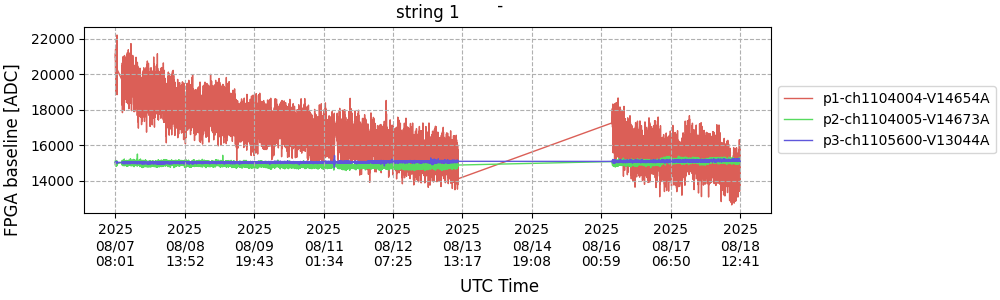

In [21]:
# set plotting options
plot_info = {
    "unit": df_info.loc["unit", "Value"],
    "label": df_info.loc["label", "Value"],
    "lower_lim_var": (
        float(df_info.loc["lower_lim_var", "Value"])
        if limits_buttons.value == "yes"
        and to_None(df_info.loc["lower_lim_var", "Value"]) is not None
        else None
    ),
    "upper_lim_var": (
        float(df_info.loc["upper_lim_var", "Value"])
        if limits_buttons.value == "yes"
        and to_None(df_info.loc["upper_lim_var", "Value"]) is not None
        else None
    ),
    "lower_lim_abs": (
        float(df_info.loc["lower_lim_abs", "Value"])
        if limits_buttons.value == "yes"
        and to_None(df_info.loc["lower_lim_abs", "Value"]) is not None
        else None
    ),
    "upper_lim_abs": (
        float(df_info.loc["upper_lim_abs", "Value"])
        if limits_buttons.value == "yes"
        and to_None(df_info.loc["upper_lim_abs", "Value"]) is not None
        else None
    ),
    "plot_style": plot_styles_widget.value,
    "plot_structure": plot_structures_widget.value,
    "resampled": resampled_widget.value,
    "title": "",
    "subsystem": "",
    "std": False,
    "locname": {
        "geds": "string",
        "spms": "fiber",
        "pulser": "puls",
        "pulser01ana": "pulser01ana",
        "FCbsln": "FC bsln",
        "muon": "muon",
    }[subsystem],
    "range": (
        [min_input.value, max_input.value]
        if min_input.value < max_input.value
        else [None, None]
    ),
    "event_type": None,
    "unit_label": (
        "%" if data_format_widget.value == "% values" else df_info.loc["unit", "Value"]
    ),
    "parameters": "",
    "time_window": radio_buttons.value.split("min")[0] + "T",
}


# turn on the std when plotting individual channels together
if plot_info["plot_structure"] == "per channel":
    plot_info["std"] = True

if data_format_widget.value == "absolute values":
    plot_info["limits"] = [plot_info["lower_lim_abs"], plot_info["upper_lim_abs"]]
    plot_info["parameter"] = (
        convert_to_original_format(param_widget.value)
        if param_widget.value != "BlMean"
        else param_widget.value
    )
    df_to_plot = new_df_param_orig.copy()
if data_format_widget.value == "% values":
    plot_info["limits"] = [plot_info["lower_lim_var"], plot_info["upper_lim_var"]]
    plot_info["parameter"] = (
        convert_to_original_format(param_widget.value) + "_var"
        if param_widget.value != "BlMean"
        else param_widget.value + "_var"
    )
    df_to_plot = new_df_param_var.copy()

print(f"Making plots now...")

if isinstance(strings_widget.value, str):  # let's get all strings in output
    strings = strings_widg.remove("all")
    for string in strings:
        if plot_structures_widget.value == "per channel":
            plotting.plot_per_ch(
                df_to_plot[df_to_plot["location"] == string], plot_info, ""
            )  # plot one canvas per channel
        elif plot_structures_widget.value == "per string":
            plotting.plot_per_string(
                df_to_plot[df_to_plot["location"] == string], plot_info, ""
            )  # plot one canvas per string
else:  # let's get one string in output
    if plot_structures_widget.value == "per channel":
        plotting.plot_per_ch(
            df_to_plot[df_to_plot["location"] == strings_widget.value], plot_info, ""
        )  # plot one canvas per channel
    elif plot_structures_widget.value == "per string":
        plotting.plot_per_string(
            df_to_plot[df_to_plot["location"] == strings_widget.value], plot_info, ""
        )  # plot one canvas per string